In [1]:
# Download coastlines shapefile from: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/
# Cut the domain of interest from the full resolution shapefile
!ogr2ogr -f "ESRI Shapefile" C:/Users/panmits86/Desktop/Python/gshhg-shp-2.3.7/GSHHS_shp/f/GSHHS_f_L1_SNE.shp C:/Users/panmits86/Desktop/Python/gshhg-shp-2.3.7/GSHHS_shp/f/GSHHS_f_L1.shp -clipsrc -74 -70 40 42

In [2]:
import numpy as np
from datetime import datetime
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd

import gdal
import cmocean
import cmaps

%matplotlib inline

In [3]:
#SARAL-ALtiKa data

ds1 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/SARAL-AltiKa/IGDR/2018_Q1/SRL_IPN_2PTP1*.nc')
wave_heights_sa = ds1['swh']
# apply a surface type flag. type 3 = land, type 0 = ocean.
surface_type_sa = ds1['surface_type']
wht_sa = wave_heights_sa[surface_type_sa < 3.]
wh_sa = wht_sa[wht_sa < 11.]
wh_sa

C:\Users\panmits86\Anaconda3\envs\gallery\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\panmits86\Anaconda3\envs\gallery\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
C:\Users\panmits86

<xarray.DataArray 'swh' (time: 547)>
dask.array<getitem, shape=(547,), dtype=float32, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
    lat      (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    lon      (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2018-01-03T10:23:38.547059072 ... 2018-03-31T10:10:37.478988160
Attributes:
    comment:        All instrumental corrections included, i.e. modeled instr...
    long_name:      Corrected significant waveheight
    quality_flag:   qual_alt_1hz_swh
    standard_name:  sea_surface_wave_significant_height
    units:          m

In [4]:
#Jason 3 Data

ds2 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/JASON_3/IGDR/2018_Q1/JA3_IPN_2PdP*.nc')
wave_heights_ja = ds2['swh_ku']
# apply a surface type flag. type 3 = land, type 0 = ocean.
surface_type_ja = ds2['surface_type']
wht_ja = wave_heights_ja[surface_type_ja < 1.]
# apply significant wave height values flag
wh_ja = wht_ja[wht_ja < 11.]
wh_ja

C:\Users\panmits86\Anaconda3\envs\gallery\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\panmits86\Anaconda3\envs\gallery\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
C:\Users\panmits86

<xarray.DataArray 'swh_ku' (time: 734)>
dask.array<getitem, shape=(734,), dtype=float32, chunksize=(33,), chunktype=numpy.ndarray>
Coordinates:
    lat      (time) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    lon      (time) float64 dask.array<chunksize=(31,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2018-01-01T04:14:35.975542080 ... 2018-03-31T10:02:01.227417024
Attributes:
    comment:        All instrumental corrections included, i.e. modeled instr...
    long_name:      Ku band corrected significant waveheight
    quality_flag:   qual_alt_1hz_swh_ku
    standard_name:  sea_surface_wave_significant_height
    units:          m

In [5]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

In [6]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

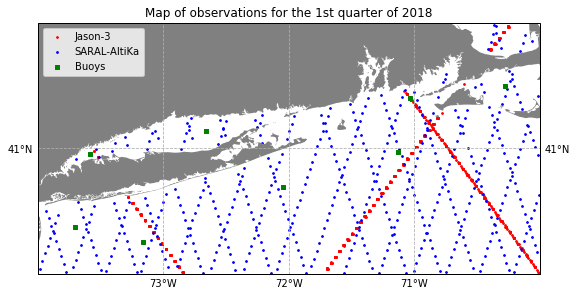

In [7]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the buoys and satellite observations for the 1st quarter of 2017.
plt.scatter(wh_ja['lon'], wh_ja['lat'], s=3, marker='o', color='red', label='Jason-3',
             transform=ccrs.Geodetic())
plt.scatter(wh_sa['lon'], wh_sa['lat'], s=3, marker='o', color='blue', label='SARAL-AltiKa',
            transform=ccrs.Geodetic())
plt.scatter(buoys['Longitude'], buoys['Latitude'], s=10, marker='s', color='green', label='Buoys',
            transform=ccrs.Geodetic())
ax.legend(loc='upper left')
ax.set_title('Map of observations for the 1st quarter of 2018')
plt.savefig('SNE_obs.png', dpi=300, bbox_inches='tight')

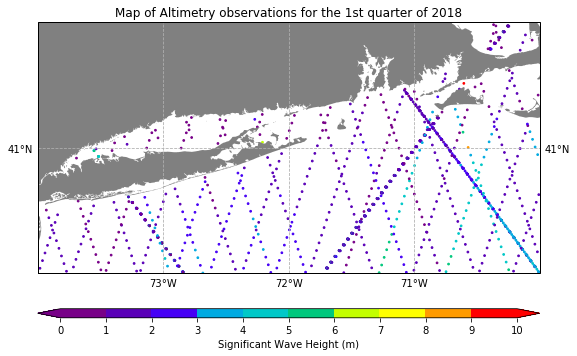

In [8]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations for the 1st quarter of 2018.
cmap=cmaps.cosam
bounds = np.array([0,1,2,3,4,5,6,7,8,9,10])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
cs1 = plt.scatter(wh_ja['lon'], wh_ja['lat'], c=wh_ja, s=3, marker='o', cmap=cmap, norm=norm,
             transform=ccrs.Geodetic())
cs2 = plt.scatter(wh_sa['lon'], wh_sa['lat'], c=wh_sa, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs1,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('Map of Altimetry observations for the 1st quarter of 2018')
plt.savefig('SNE_obs_alt.png', dpi=300, bbox_inches='tight')